In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2
import os
import matplotlib.pyplot as plt

In [3]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/archive (2)"

Mounted at /content/drive


In [160]:
def order_pics(pics):
    ordered_pics = []
    ordered_targ = []
    for i in range(41):
        num = i + 1
        for pic in pics:
            if int(pic.split('_')[1].replace('.jpg','')) == num:
                ordered_pics.append(pic)
                ordered_targ.append(num)
    return ordered_pics, ordered_targ
    
def load_images_from_folder(folder):
    images = []
    pics = os.listdir(folder)
    pics, target = order_pics(pics)
    for filename in pics:
        img = cv2.imread(os.path.join(folder,filename)) # read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # transform to grayscale
        img = cv2.resize(img, (80, 80), interpolation = cv2.INTER_AREA) # resize to 80x80
        if img is not None:
            images.append(img)
    return images, target

# Load ORL Dataset 

In [161]:
folder = path
X, y = load_images_from_folder(folder)

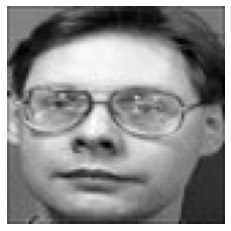

In [122]:
plt.axis('off')
plt.imshow(np.array(X)[31],cmap='gray')

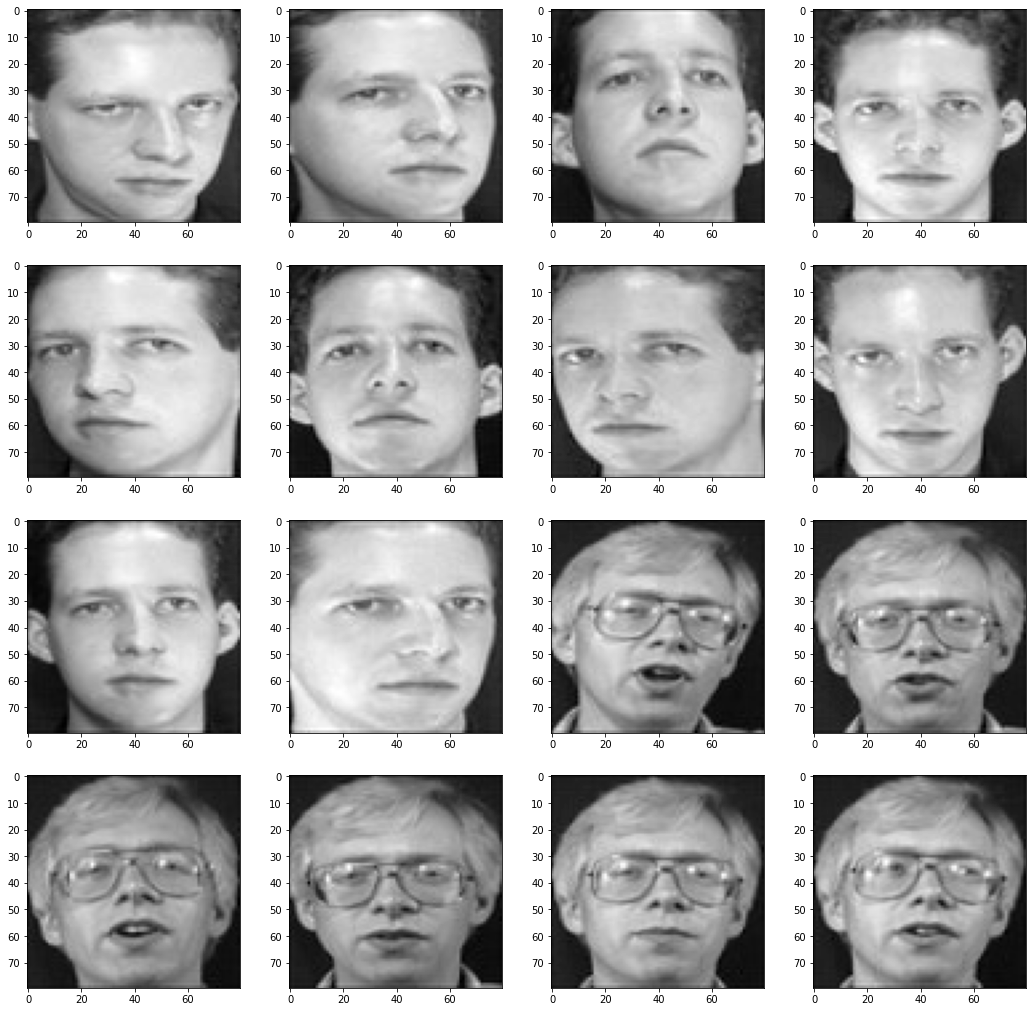

In [115]:
fig, axes = plt.subplots(4,4, figsize=(18, 18))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.array(X)[i].reshape(80, 80), cmap='gray')

In [110]:
X_train = list()
X_test = list()
y_train = list()
y_test = list()
for i in range(0, len(X)-10, 10): # starts on index zero until the length of X for each 10
    person_X = X[i:i+10]
    person_y = y[i:i+10]
    X_train_Person, X_test_Person, y_train_Person, y_test_Person = train_test_split(person_X, person_y, 
                                                                                    test_size=0.2, random_state=14)
    X_train.extend(X_train_Person)
    X_test.extend(X_test_Person)
    y_train.extend(y_train_Person)
    y_test.extend(y_test_Person)

In [41]:
X_unknow_test = X[401:410]
y_unknow_test = y[401:410]

In [111]:
X_train = np.array(X_train)
X_train = X_train.reshape(320,80,80)
X_test = np.array(X_test)
X_test = X_test.reshape(80,80,80)
y_train = np.array(y_train)
y_test = np.array(y_test)

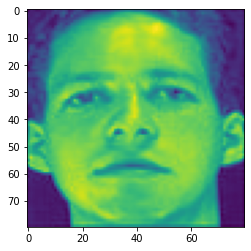

In [112]:
plt.imshow(X_train[1])

In [43]:
X_train = X_train.reshape(320,6400)
X_test = X_test.reshape(80,6400)

**Fisher faces Method**

In [44]:
# Compute the PCA transformation on the training data
n_components = 50
pca = PCA(n_components)  # choose the number of components
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


# Compute the class means
class_means = []
for i in range(1, 41):  # there are 40 subjects in the dataset
    class_i_indices = np.where(y_train == i)[0]
    class_i_mean = np.mean(X_train_pca[class_i_indices], axis=0)
    class_means.append(class_i_mean)

# Compute the within-class scatter matrix
S_w = np.zeros((n_components, n_components))
for i in range(1, 41):
    class_i_indices = np.where(y_train == i)[0]
    class_i_scatter = np.zeros((n_components, n_components))
    for j in class_i_indices:
        diff = (X_train_pca[j] - class_means[i-1]).reshape(-1, 1)
        class_i_scatter += np.dot(diff, diff.T)
    S_w += class_i_scatter

# Compute the between-class scatter matrix
overall_mean = np.mean(X_train_pca, axis=0)
S_b = np.zeros((n_components, n_components))
for i in range(1, 41):
    n_i = np.sum(y_train == i)
    diff = (class_means[i-1] - overall_mean).reshape(-1, 1)
    S_b += n_i * np.dot(diff, diff.T)

# Compute the Fisherfaces
S_w_inv = np.linalg.inv(S_w)
S_w_inv_S_b = np.dot(S_w_inv, S_b)
eigvals, eigvecs = np.linalg.eig(S_w_inv_S_b)
idx = eigvals.argsort()[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]
print(eigvecs.shape)
W_fisher = eigvecs[:, :48]  # choose the number of Fisherfaces

# Project the data onto the Fisherface subspace
X_train_fisher = np.dot(X_train_pca, W_fisher)
X_test_fisher = np.dot(X_test_pca, W_fisher)
X_train_fisher.shape

(50, 50)


(320, 48)

In [45]:
X_train_fisher = X_train_fisher.astype("float32")

<ipython-input-45-7f9841f09bfa>:1: ComplexWarning: Casting complex values to real discards the imaginary part
  X_train_fisher = X_train_fisher.astype("float32")


Showing the Fisher Faces


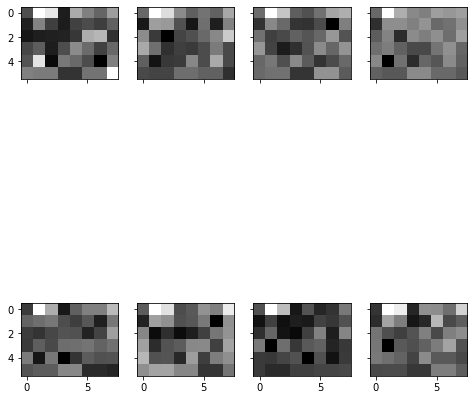

Showing the Fisher Faces


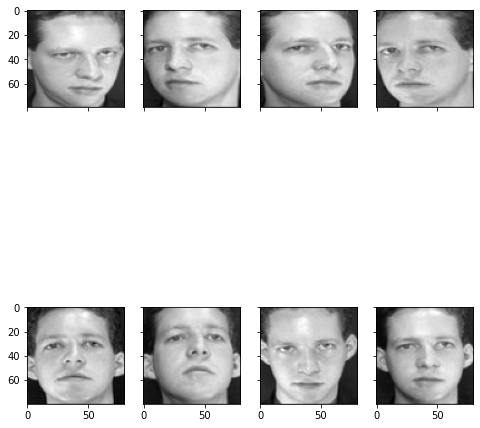

In [78]:
# Show the first 16 eigenfaces
fig, axes = plt.subplots(2,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(8):
    axes[i%2][i//2].imshow(X_train_fisher[i].reshape(6,8), cmap="gray")
print("Showing the Fisher Faces")
plt.show()

fig, axes = plt.subplots(2,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(8):
    axes[i%2][i//2].imshow(X_train[i].reshape(80,80), cmap="gray")
print("Showing the Fisher Faces")
plt.show()


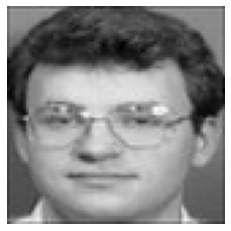

In [146]:
plt.axis('off')
plt.imshow(np.array(X_train_fisher[41].reshape(6,8)),cmap='gray')
plt.imshow(np.array(X_train)[41],cmap='gray')

**Results for ORL Dataset by Fisher face method**

In [79]:
# Perform classification using Euclidean distance
y_pred = []
for i in range(X_test_fisher.shape[0]):
    distances = []
    for j in range(X_train_fisher.shape[0]):
        dist = np.linalg.norm(X_test_fisher[i] - X_train_fisher[j])
        distances.append(dist)
    nearest_neighbor = np.argmin(distances)
    y_pred.append(y_train[nearest_neighbor])

# Compute the accuracy
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)
precision = precision_score(y_test, y_pred,average='macro')
print("Precision:")
print(precision)
recall = recall_score(y_test, y_pred,average='macro')
print("Recall:")
print(recall)
f1_score = f1_score(y_test, y_pred,average='macro')
print("F1 score:")
print(f1_score)

Accuracy: 0.9625
Confusion matrix:
[[1 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]
Precision:
0.975
Recall:
0.9625
F1 score:
0.9599999999999997


**Local Binary Patten method on ORL dataset**



In [81]:
# For ORL dataset
X_train = X_train.reshape(320,80,80)
X_test = X_test.reshape(80,80,80)

# Train the LBP face recognizer on the training data
recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.train(X_train, y_train)
recognizer.write('trained_data.xml')
y_pred = []
# Test the LBP face recognizer on the test data
correct = 0
for i in range(len(X_test)):
    img = X_test[i]
    label, confidence = recognizer.predict(img)
    y_pred.append(label)
    if label == y_test[i]:
        correct += 1

accuracy = correct / len(X_test)
print('Accuracy:', accuracy)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)
precision = precision_score(y_test, y_pred,average='macro')
print("Precision:")
print(precision)
recall = recall_score(y_test, y_pred,average='macro')
print("Recall:")
print(recall)
f1_score = f1_score(y_test, y_pred,average='macro')
print("F1 score:")
print(f1_score)

Accuracy: 0.9875
Confusion matrix:
[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]
Precision:
0.9916666666666668
Recall:
0.9875
F1 score:
0.9866666666666667


Load AT&T dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Showing sample faces


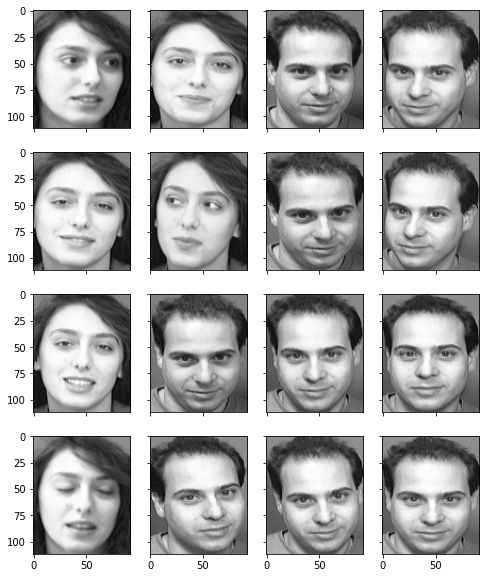

Face image shape: (112, 92)
Number of classes: 40
Number of images: 400


In [96]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/archive (3).zip"

import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Read face image from zip file on the fly
faces = {}
with zipfile.ZipFile(r"/content/drive/MyDrive/archive (3).zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            # If we extracted files from zip, we can use cv2.imread(filename) instead
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

# Show sample faces using matplotlib
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
faceimages = list(faces.values())[-16:] # take last 16 images
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
print("Showing sample faces")
plt.show()

# Print some details
faceshape = list(faces.values())[0].shape
print("Face image shape:", faceshape)

classes = set(filename.split("/")[0] for filename in faces.keys())
print("Number of classes:", len(classes))
print("Number of images:", len(faces))

# Take classes 1-39 for eigenfaces, keep entire class 40 and
# image 10 of class 39 as out-of-sample test
facematrix = []
facelabel = []
testmatrix = []
testlabel = []
for key,val in faces.items():
    facematrix.append(val.flatten())
    facelabel.append(key.split("/")[0][1:])

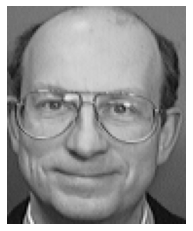

In [130]:
plt.axis('off')
plt.imshow((np.array(facematrix)[41]).reshape(112,92),cmap='gray',)

In [97]:
X_train = list()
X_test = list()
y_train = list()
y_test = list()
for i in range(0, len(facematrix), 10): # starts on index zero until the length of X for each 10
    person_X = facematrix[i:i+10]
    person_y = facelabel[i:i+10]
    X_train_Person, X_test_Person, y_train_Person, y_test_Person = train_test_split(person_X, person_y, 
                                                                                    test_size=0.2, random_state=14)
    X_train.extend(X_train_Person)
    X_test.extend(X_test_Person)
    y_train.extend(y_train_Person)
    y_test.extend(y_test_Person)

In [98]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train,dtype=int)
y_test = np.array(y_test,dtype=int)

In [86]:
y_test

array([ 1,  1, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17,
       17, 18, 18, 19, 19,  2,  2, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24,
       25, 25, 26, 26, 27, 27, 28, 28, 29, 29,  3,  3, 30, 30, 31, 31, 32,
       32, 33, 33, 34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39,  4,  4,
       40, 40,  5,  5,  6,  6,  7,  7,  8,  8,  9,  9])

**Fisher Faces Method on AT&T dataset**

In [99]:
# Compute the PCA transformation on the training data
n_components = 50
pca = PCA(n_components)  # choose the number of components
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


# Compute the class means
class_means = []
for i in range(1, 41):  # there are 40 subjects in the dataset
    class_i_indices = np.where(y_train == i)[0]
    class_i_mean = np.mean(X_train_pca[class_i_indices], axis=0)
    class_means.append(class_i_mean)

# Compute the within-class scatter matrix
S_w = np.zeros((n_components, n_components))
for i in range(1, 41):
    class_i_indices = np.where(y_train == i)[0]
    class_i_scatter = np.zeros((n_components, n_components))
    for j in class_i_indices:
        diff = (X_train_pca[j] - class_means[i-1]).reshape(-1, 1)
        class_i_scatter += np.dot(diff, diff.T)
    S_w += class_i_scatter

# Compute the between-class scatter matrix
overall_mean = np.mean(X_train_pca, axis=0)
S_b = np.zeros((n_components, n_components))
for i in range(1, 41):
    n_i = np.sum(y_train == i)
    diff = (class_means[i-1] - overall_mean).reshape(-1, 1)
    S_b += n_i * np.dot(diff, diff.T)

# Compute the Fisherfaces
S_w_inv = np.linalg.inv(S_w)
S_w_inv_S_b = np.dot(S_w_inv, S_b)
eigvals, eigvecs = np.linalg.eig(S_w_inv_S_b)
idx = eigvals.argsort()[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]
print(eigvecs.shape)
W_fisher = eigvecs[:, :48]  # choose the number of Fisherfaces

# Project the data onto the Fisherface subspace
X_train_fisher = np.dot(X_train_pca, W_fisher)
X_test_fisher = np.dot(X_test_pca, W_fisher)
X_train_fisher.shape

(50, 50)


(320, 48)

In [100]:
X_train_fisher = X_train_fisher.astype("float32")

<ipython-input-100-7f9841f09bfa>:1: ComplexWarning: Casting complex values to real discards the imaginary part
  X_train_fisher = X_train_fisher.astype("float32")


Showing the Fisher Faces


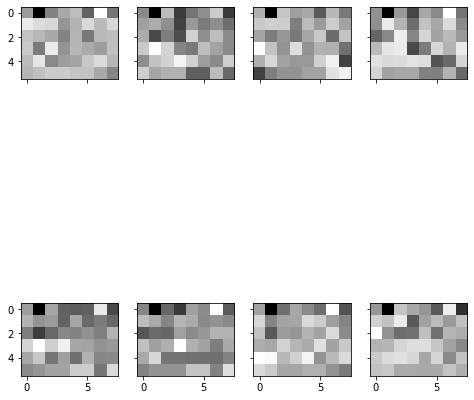

Showing the Fisher Faces


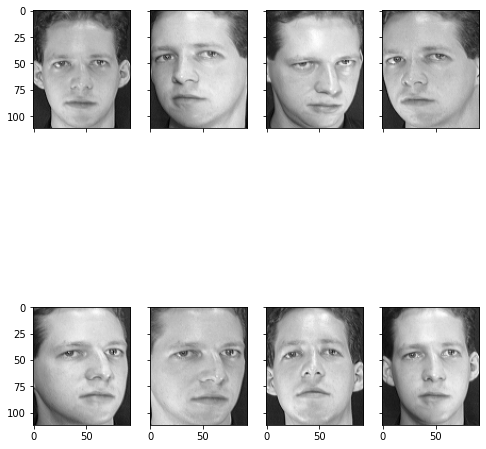

In [101]:
# Show the first 16 eigenfaces
fig, axes = plt.subplots(2,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(8):
    axes[i%2][i//2].imshow(X_train_fisher[i].reshape(6,8), cmap="gray")
print("Showing the Fisher Faces")
plt.show()
fig, axes = plt.subplots(2,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(8):
    axes[i%2][i//2].imshow(X_train[i].reshape(112,92), cmap="gray")
print("Showing the Fisher Faces")
plt.show()

In [102]:
# Perform classification using Euclidean distance
y_pred = []
for i in range(X_test_fisher.shape[0]):
    distances = []
    for j in range(X_train_fisher.shape[0]):
        dist = np.linalg.norm(X_test_fisher[i] - X_train_fisher[j])
        distances.append(dist)
    nearest_neighbor = np.argmin(distances)
    y_pred.append(y_train[nearest_neighbor])

# Compute the accuracy
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9875


In [103]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)
precision = precision_score(y_test, y_pred,average='macro')
print("Precision:")
print(precision)
recall = recall_score(y_test, y_pred,average='macro')
print("Recall:")
print(recall)
f1_score = f1_score(y_test, y_pred,average='macro')
print("F1 score:")
print(f1_score)

Confusion matrix:
[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]
Precision:
0.9916666666666668
Recall:
0.9875
F1 score:
0.9866666666666667


**Local Binary Pattern method on AT&T Dataset**

In [104]:
# For ORL dataset
X_train = X_train.reshape(320,112,92)
X_test = X_test.reshape(80,112,92)

# Train the LBP face recognizer on the training data
recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.train(X_train, y_train)
recognizer.write('trained_data.xml')
y_pred = []
# Test the LBP face recognizer on the test data
correct = 0
for i in range(len(X_test)):
    img = X_test[i]
    label, confidence = recognizer.predict(img)
    y_pred.append(label)
    if label == y_test[i]:
        correct += 1

accuracy = correct / len(X_test)
print('Accuracy:', accuracy)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)
precision = precision_score(y_test, y_pred,average='macro')
print("Precision:")
print(precision)
recall = recall_score(y_test, y_pred,average='macro')
print("Recall:")
print(recall)
f1_score = f1_score(y_test, y_pred,average='macro')
print("F1 score:")
print(f1_score)

Accuracy: 0.9875
Confusion matrix:
[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]
Precision:
0.9916666666666666
Recall:
0.9875
F1 score:
0.9866666666666667
